# Eurozone CPI, ECB Deposit Facility, Marginal Lending Facility rates, Market Yield on Government Bonds at 10-Year, and Eurozone Riskless Yield Curve
This notebook jaxteposes the evolution of Eurozone CPI with ECB Deposit Facility Rate and 10 year Government Bond yields. It then looks at the the relationship between riskfree rates (e.g. 10-year AAA-rated eurozone central government bonds rates) and Eurozone CPI + real GDP growth rates. CPI + GDP growth rates is known as _the intrinsic riskfree rate_. In theory the 10-year AAA-rated eurozone central government bond rate such as that for 10-Year Germany government bonds should be similar to the intrinsic riskfree rate. This notebook looks at how this played out since the 90's.

Finally, I look at the evolution of the Euro riskless rate curve as defined by the yields on AAA-rated eurozone central government bonds.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/US_Economic_Data_Analysis.git cloned-repo
#%cd cloned-repo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import MonthBegin, BDay, QuarterBegin

from datetime import date
import re

from dateutil.relativedelta import relativedelta

from pricing import curves

In [3]:
report_start = date.fromisoformat('1996-01-01')
report_end = date.today()

### Get Consumer Price Index for Eurozone (19 countries), ECB Deposit Facility Rate, 10 Year Government Bond Yields, and Real GDP
I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `CP0000EZ19M086NEST` &mdash; Harmonized Index of Consumer Prices: All Items for Euro area (19 countries) (monthly frequency, from 1996)
* `ECBDFR` &mdash; ECB Deposit Facility Rate for Euro Area (daily frequency, from 1999)
* `ECBMLFR` &mdash; ECB Marginal Lending Facility Rate for Euro Area (daily frequency, from 1999)
* `IRLTLT01DEM156N` &mdash; Long-Term Government Bond Yields: 10-year Germany (monthly frequency, from 1960)
* `IRLTLT01ITM156N` &mdash; Long-Term Government Bond Yields: 10-year Italy (monthly frequency, from 1960)

And the following dataseries provided by the [Eurostat](https://ec.europa.eu/eurostat/web/main/data/database):
* `irt_lt_mcby_m` &mdash; EMU convergence criterion series (monthly frequency). This series returns a MultiIndexed dataset containing Long-Term Government Bond Yields for the Eurozone at 10-year maturity. I use it instead of the `IRLTLT01DEM156N` and `IRLTLT01ITM156N` datasets returned by FRED given that Eurostat's datbase tends to be updated earlier than that of FRED for Eurozone data.

There's a relationship between the riskless rate as represented by AAA-rated eurozone central government bonds rates on the one hand and real GDP growth and inflation rates on the other hand. I use 10-year Germany Bond Yields as proxy for riskless long-term rates given Germany's AAA credit rating. At the end of this section I look at real GDP developments in conjunction with CPI, for which I make use of the following additional dataseries from [FRED](https://fred.stlouisfed.org/):
* `CLVMEURSCAB1GQEA19` — Real Gross Domestic Product (Euro/ECU series) for Euro area (19 countries), Millions of Chained 2010 Euros, Seasonally Adjusted (quarterly frequency). The corresponding Eurostat dataseries is `namq_10_gdp`.

In [4]:
cpi_ecbr_irtlt = web.get_data_fred(['CP0000EZ19M086NEST', 'IRLTLT01DEM156N', 'IRLTLT01ITM156N'], start=report_start, end=report_end)
ecbr = web.get_data_fred(['ECBDFR', 'ECBMLFR'], start=report_start, end=report_end)
real_gdp = web.get_data_fred('CLVMEURSCAB1GQEA19', start=report_start, end=report_end)

# Make frequencies explicit, resample to month srart
cpi_ecbr_irtlt = cpi_ecbr_irtlt.asfreq('MS')
ecbr = ecbr.asfreq('D').resample('MS').last()

# Kludge to get an estimate of the December CPI estimate
# if cpi_ecbr_irtlt.index[-1] < pd.Timestamp(2022, 12, 1):
#     cpi_ecbr_irtlt.at['2022-12-01', 'CP0000EZ19M086NEST'] = 120.53
    
# Since CP0000EZ19M086NEST is indexed to 2015=100, we need to convert it to annual percentage changes
cpi_ecbr_irtlt.update(cpi_ecbr_irtlt.CP0000EZ19M086NEST.pct_change(12))

# Merge and truncate to start of celendar year 1999.
cpi_ecbr_irtlt = pd.concat([cpi_ecbr_irtlt, ecbr], axis=1).loc['1999':]

cpi_ecbr_irtlt = cpi_ecbr_irtlt[['CP0000EZ19M086NEST', 'ECBDFR', 'ECBMLFR', 'IRLTLT01DEM156N', 'IRLTLT01ITM156N']]

real_gdp = real_gdp.pct_change(4, fill_method='bfill')

DE_YIELD_LABEL = '10y German Government Bond Yield'
IT_YIELD_LABEL = '10y Italian Government Bond Yield'
cpi_ecbr_irtlt.rename(
    columns={'CP0000EZ19M086NEST': 'Annual Eurozone CPI',
             'ECBDFR': 'ECB Deposit Facility Rate', 'ECBMLFR': 'ECB Marginal Lending Facility Rate',
             'IRLTLT01DEM156N': DE_YIELD_LABEL,
             'IRLTLT01ITM156N': IT_YIELD_LABEL},
    inplace=True)
real_gdp.rename(columns={'CLVMEURSCAB1GQEA19': 'Real GDP'}, inplace=True)
real_gdp['Real GDP Moving Avg (4Q)'] = real_gdp.iloc[:,0].rolling(4).mean()
real_gdp = real_gdp.loc['1999':]

In [5]:
# Since FRED's database is updated less frequently for Eurozone data than that of Eurostat,
# retrieving the most recent government bond yields from Eurostat's database
EUROSTAT_DE_COUNTRY_LABEL = 'Germany (until 1990 former territory of the FRG)'
EUROSTAT_IT_COUNTRY_LABEL = 'Italy'
eu_irt_lt = web.DataReader('irt_lt_mcby_m', 'eurostat', start=report_start, end=report_end)
eu_irt_lt = eu_irt_lt.sort_index(axis=1).loc[:, ('EMU convergence criterion bond yields',
                              [EUROSTAT_DE_COUNTRY_LABEL, EUROSTAT_IT_COUNTRY_LABEL])].droplevel([0,2], axis=1)
eu_irt_lt.rename(
    columns={EUROSTAT_DE_COUNTRY_LABEL: DE_YIELD_LABEL,
             EUROSTAT_IT_COUNTRY_LABEL: IT_YIELD_LABEL},
    inplace=True)

# Override last year's data with Eurostat's values
cpi_ecbr_irtlt.loc['2022':, [DE_YIELD_LABEL, IT_YIELD_LABEL]] = eu_irt_lt.loc['2022':]

# Calculate the mean rate for the current month and, if needed, for the one before too
rmth_start = cpi_ecbr_irtlt.index[-2 if pd.isna(cpi_ecbr_irtlt.iloc[-2, -1]) else -1].date()

eu_irt_lt_cur_mth = web.DataReader('irt_lt_mcby_d', 'eurostat', start=rmth_start)
eu_irt_lt_cur_mth = eu_irt_lt_cur_mth.sort_index(axis=1).loc[:, ('EMU convergence criterion bond yields',
                              [EUROSTAT_DE_COUNTRY_LABEL, EUROSTAT_IT_COUNTRY_LABEL])].droplevel([0,2], axis=1)
eu_irt_lt_cur_mth.rename(
    columns={EUROSTAT_DE_COUNTRY_LABEL: DE_YIELD_LABEL,
             EUROSTAT_IT_COUNTRY_LABEL: IT_YIELD_LABEL},
    inplace=True)
eu_irt_lt_cur_mth = eu_irt_lt_cur_mth.asfreq('D').resample('MS').mean()
cpi_ecbr_irtlt.loc['2022':, [DE_YIELD_LABEL, IT_YIELD_LABEL]].update(eu_irt_lt_cur_mth)
cpi_ecbr_irtlt.update(eu_irt_lt_cur_mth)

# Convert to percentage points
cpi_ecbr_irtlt.iloc[:,[1,2,3,4]] /= 100

In [6]:
pd.options.display.float_format = '{:.4%}'.format
cpi_ecbr_irtlt

,Annual Eurozone CPI,ECB Deposit Facility Rate,ECB Marginal Lending Facility Rate,10y German Government Bond Yield,10y Italian Government Bond Yield
DATE,,,,,
1999-01-01,0.8514%,2.0000%,4.5000%,3.7020%,3.9223%
1999-02-01,0.8356%,2.0000%,4.5000%,3.8490%,4.0538%
1999-03-01,1.0260%,2.0000%,4.5000%,4.0378%,4.2712%
1999-04-01,1.1326%,1.5000%,3.5000%,3.8500%,4.1102%
1999-05-01,0.9941%,1.5000%,3.5000%,4.0121%,4.2792%
...,...,...,...,...,...
2022-09-01,9.9272%,0.7500%,1.5000%,1.8000%,4.1400%
2022-10-01,10.6206%,0.7500%,1.5000%,2.1900%,4.5300%
2022-11-01,10.0546%,1.5000%,2.2500%,2.0700%,4.2400%


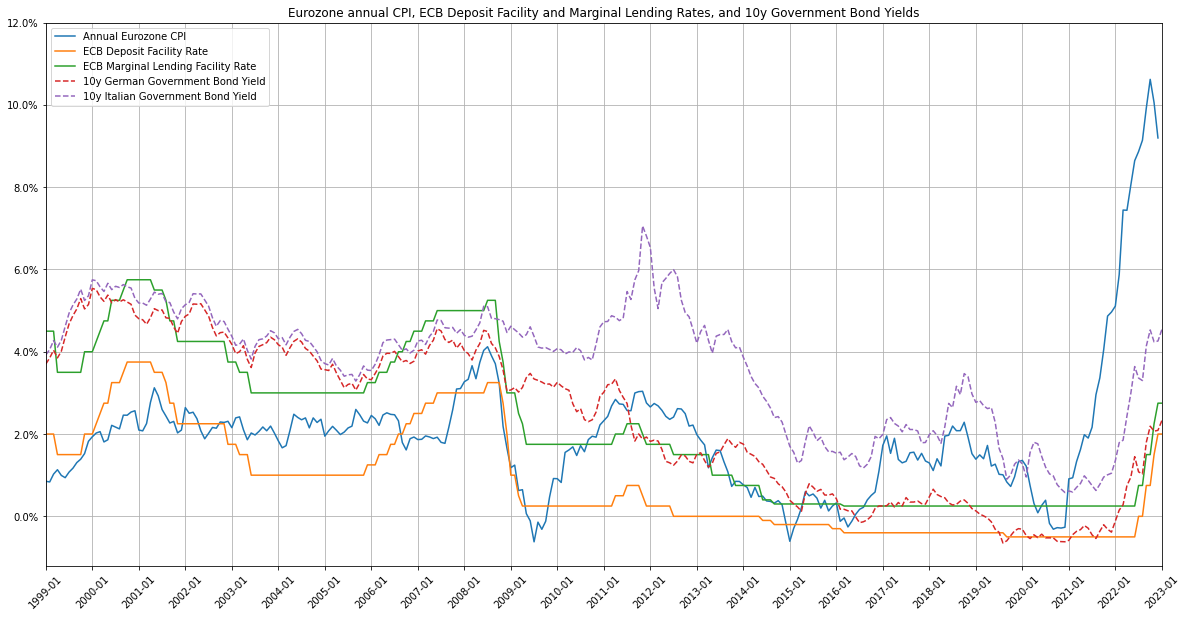

In [7]:
ax = cpi_ecbr_irtlt.iloc[:,:3].plot(figsize=(20,10), grid=True,
                        title='Eurozone annual CPI, ECB Deposit Facility and Marginal Lending Rates, and 10y Government Bond Yields',
                        xticks=cpi_ecbr_irtlt.index[::12], xlabel='', rot=45, yticks=np.arange(0, .13, .02))
cpi_ecbr_irtlt.iloc[:,3:].plot(ax=ax, linestyle='--', grid=True,
                        xticks=cpi_ecbr_irtlt.index[::12], xlabel='', rot=45, yticks=np.arange(0, .13, .02))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, cpi_ecbr_irtlt.index[::12])))

In [8]:
real_gdp.loc['2020':]

,Real GDP,Real GDP Moving Avg (4Q)
DATE,,
2020-01-01,-2.8442%,0.4344%
2020-04-01,-14.2377%,-3.5264%
2020-07-01,-3.8445%,-4.9393%
2020-10-01,-4.1119%,-6.2596%
2021-01-01,-0.8358%,-5.7575%
2021-04-01,14.2111%,1.3547%
2021-07-01,3.9434%,3.3017%
2021-10-01,4.7746%,5.5233%
2022-01-01,5.4806%,7.1024%


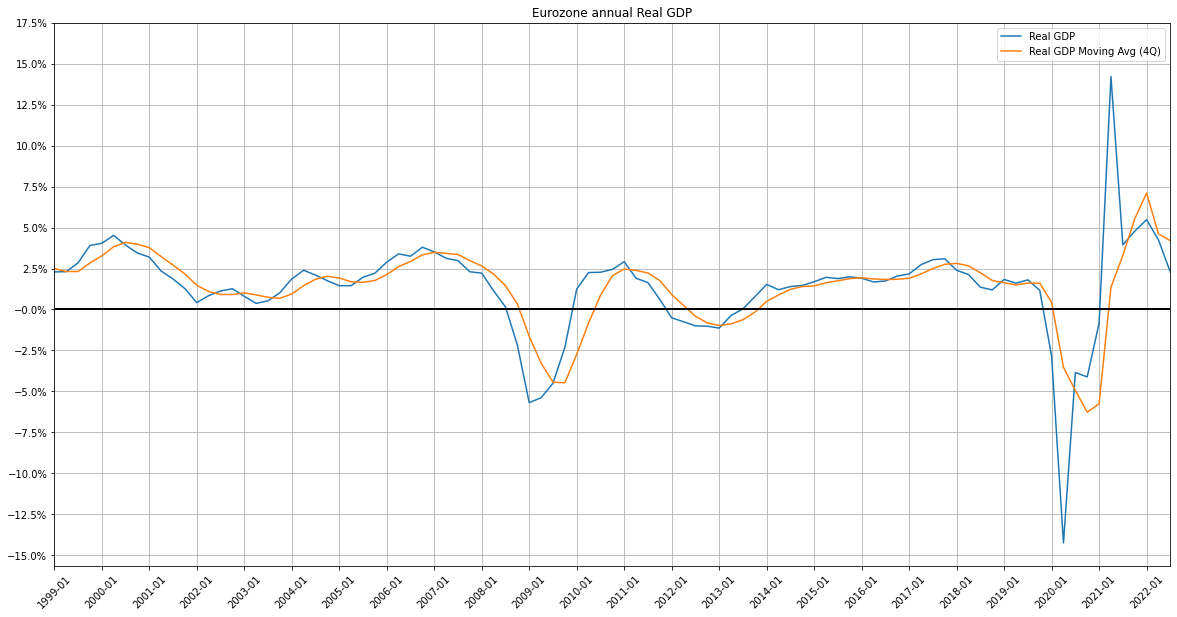

In [9]:
ax = real_gdp.plot(figsize=(20,10), grid=True, title='Eurozone annual Real GDP',
                   xticks=real_gdp.index[::4], xlabel='', rot=45, yticks=np.arange(-.15, .2, 0.025))
ax.axhline(y=0, lw=2, c='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, real_gdp.index[::4])))

In [10]:
# Including only the yield on German government bonds as those of Italy are not AAA rated and cannot be regarded
# as riskfree
df = pd.concat([real_gdp.iloc[:,0], cpi_ecbr_irtlt.iloc[:,[0,3]].resample('qs').mean()], axis=1)\
    .loc[:real_gdp.last_valid_index()] # Truncate based on last valid GDP value
df.loc['2020':]

,Real GDP,Annual Eurozone CPI,10y German Government Bond Yield
DATE,,,
2020-01-01,-2.8442%,1.1090%,-0.4403%
2020-04-01,-14.2377%,0.2217%,-0.4668%
2020-07-01,-3.8445%,-0.0313%,-0.5235%
2020-10-01,-4.1119%,-0.2754%,-0.6135%
2021-01-01,-0.8358%,1.0597%,-0.4646%
2021-04-01,14.2111%,1.8360%,-0.2790%
2021-07-01,3.9434%,2.8279%,-0.4509%
2021-10-01,4.7746%,4.6274%,-0.3007%
2022-01-01,5.4806%,6.1422%,0.1033%


### Visualizing the relationship between 10y German Bund Yield and the Intrinsic Riskfree rate (real GDP growth + inflation rates)
I use Germany 10-year government bond yield as a representative of a Eurozone central government bond with an AAA credit rating in the below graph. It is a proxy for the actual long-term riskfree rate in the Eurozone. I compare it with the intrinsic riskfree rate as defined by the sum of real GDP growth and inflation rates.

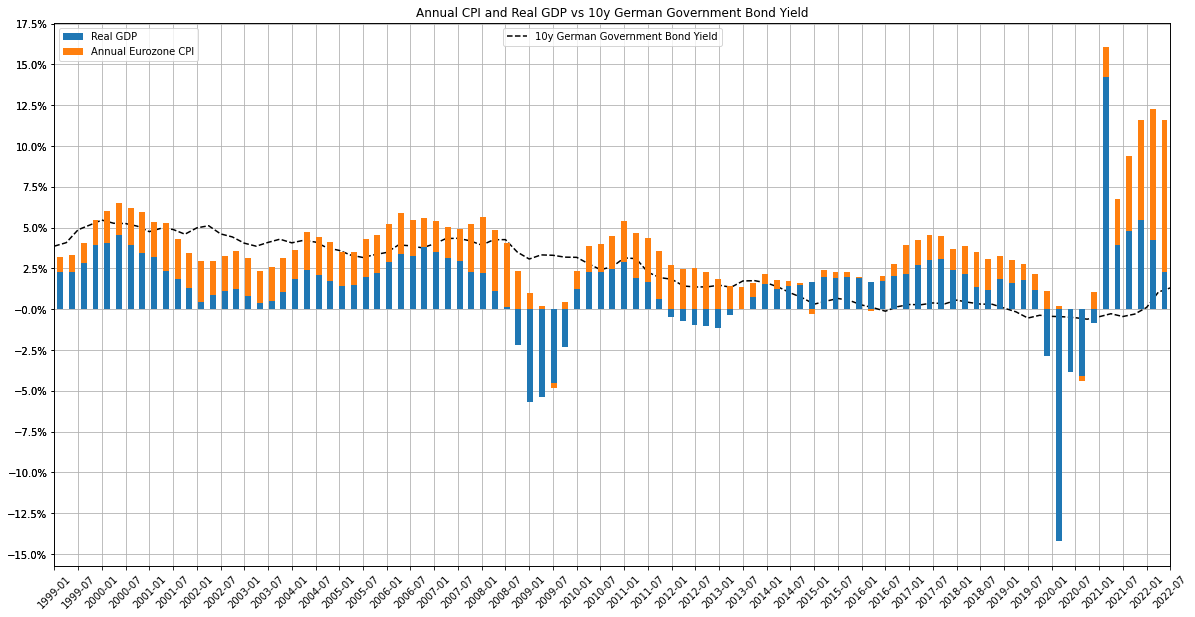

In [11]:
ax = df.iloc[:, -1].plot(figsize=(20,10), grid=True,
                         title='Annual CPI and Real GDP vs ' + DE_YIELD_LABEL,
                         xticks=df.index[::2], xlabel='', rot=45,
                         yticks=np.arange(-.15, .2, 0.025), linestyle='--', color='k')
ax2 = ax.twiny()
df.iloc[:,[0,1]].plot.bar(ax=ax2, xlabel='', stacked=True)
ax.legend(loc='upper center')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, df.index[::2])))

In [12]:
print('Gap between intrinsic (GDP+CPI) and actual (10-y German Bund) riskfree rates: {:.2%}\n'
      'Compared with: {:.2%} one quarter earlier'.format(
    df.iloc[-1,0] + df.iloc[-1,1] - df.iloc[-1,2], df.iloc[-2,0] + df.iloc[-2,1] - df.iloc[-2,2]))

Gap between intrinsic (GDP+CPI) and actual (10-y German Bund) riskfree rates: 10.29%
Compared with: 11.24% one quarter earlier


## A quick look at wage inflation in the Eurozone
In contrast to U.S. Bureau of Labor Statistics, unfortunately Eurostat is typically lags by one quarter in publishing data on wage inflation and publishes them only with quarterly frequencies.

I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `LCEAPR01EZQ661S` &mdash; Labour Compensation: Earnings: Private Sector: Hourly for the Euro Area (19 Countries) (quarterly frequency, from 1996)

The corresponding [Eurostat](https://ec.europa.eu/eurostat/web/main/data/database) dataseries is this:
* `lc_lci_r2_q` &mdash; Labour cost index by NACE Rev. 2 activity - nominal value, quarterly data. This series returns a MultiIndexed dataset containing different views on this data for the Eurozone as a whole as whell as for each individual country in the EU. Unfortunately due to the size of the data returned, pandas_datareader hits query size limits when querying Eurostat API. I therefore use the same data from FRED.

In [13]:
cpi_and_wagei = web.get_data_fred('LCEAPR01EZQ661S', start=report_start, end=report_end)
cpi_and_wagei = cpi_and_wagei.pct_change(4, fill_method='bfill').dropna()
cpi_and_wagei.rename(columns={'LCEAPR01EZQ661S': 'Hourly Earnings Annual Percentage Change'}, inplace=True)
cpi_and_wagei = pd.concat([cpi_ecbr_irtlt.iloc[:,0].resample('qs').mean(), cpi_and_wagei], axis=1)\
    .loc['1999':date.today()-relativedelta(months=+3)]

In [14]:
cpi_and_wagei

,Annual Eurozone CPI,Hourly Earnings Annual Percentage Change
DATE,,
1999-01-01,0.9043%,2.5751%
1999-04-01,1.0220%,2.8815%
1999-07-01,1.1841%,3.0786%
1999-10-01,1.5790%,3.1612%
2000-01-01,2.0053%,3.0703%
...,...,...
2021-10-01,4.6274%,2.3381%
2022-01-01,6.1422%,3.3184%
2022-04-01,8.0453%,3.2229%


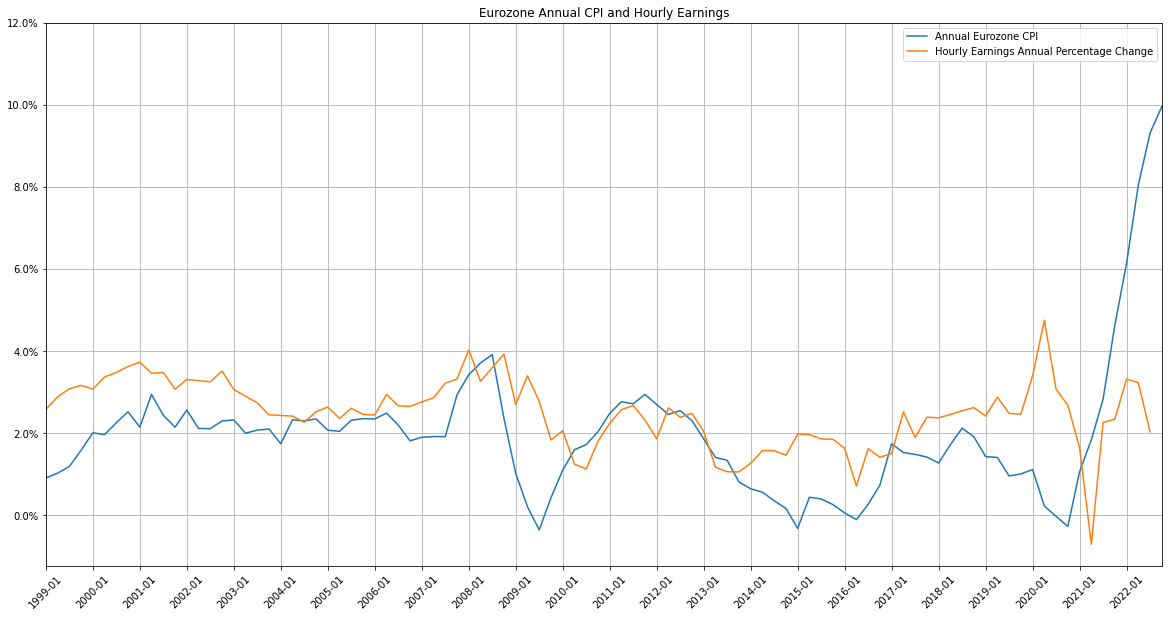

In [15]:
ax = cpi_and_wagei.plot(figsize=(20,10), grid=True,
                        title='Eurozone Annual CPI and Hourly Earnings',
                        xticks=cpi_and_wagei.index[::4], xlabel='', rot=45, yticks=np.arange(0, .13, .02))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, cpi_and_wagei.index[::4])))

## Analyzing Euro Riskless Rate Curve
In this analysis I make use of the par yield implied by AAA-rated governmental bonds in the Euro area.

I use the following dataseries provided by the [Eurostat](https://ec.europa.eu/eurostat/web/main/data/database):
* `irt_euryld_m` &mdash; Euro yield curves (monthly frequency). This series returns a MultiIndexed dataset from which multiple yields can be extraced: Instantaneous forward yield curve, Par yield curve, and Spot rate yield curve. In my analysis I use the Spor rate yield curve. The returned rates are presented using Annual percentage rates/yields and represent the average over all business days in a given month.
* `irt_st_m` &mdash; Euro EURIBOR rates (monthly frequency). EURIBOR uses the actual/360 daycount convention. This series returns a MultiIndexed dataset allowing to select different maturities. I only use the 1 month rates in this notebook as the spread between government bond rates and EURIBOR tends to increase with longer maturities. Rates returned represent the average over all business days in a given month.

And one dataset from [FRED](https://fred.stlouisfed.org):
* `ECBDFR` &mdash; ECB Deposit Facility Rate for Euro Area (daily frequency). I use it as proxy for overnight rate after downsampling to monthly frequency.

In [16]:
# Taking the last 3 months
euro_curves = web.DataReader('irt_euryld_m', 'eurostat', start=(report_end-MonthBegin(4)).date()) / 100.
mm_rates = web.DataReader('irt_st_m', 'eurostat', start=(report_end-MonthBegin(4)).date()) / 100.
ecb_deposit_rate = web.get_data_fred('ECBDFR', start=report_end-MonthBegin(4)) / 100.

# Resample to monthly frequency
ecb_deposit_rate = ecb_deposit_rate.asfreq('D').resample('MS').mean()

In [17]:
# Making use of the MultiIndex columns to select par yields based on AAA-rate government bonds
euro_par_yields = euro_curves.sort_index(axis=1).loc[:,
                        ('Spot rate yield curve', 'AAA-rated euro area central government bonds')]
#'Spot rate yield curve', 'Par yield curve'
#'All euro area central government bonds', 'AAA-rated euro area central government bonds'

mm_rates = mm_rates.sort_index(axis=1).loc[:,
    ('1-month rate',
     'Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023)')]

# Converting EURIBOR and ECB Deposit rates from actual/360 to actual/actual
leap_year_cond = lambda idx: idx.year % 4 == 0 & ((idx.year % 100 != 0) | (idx.year % 400 == 0))
mm_rates[leap_year_cond(mm_rates.index)] *= 366. / 360
mm_rates[np.invert(leap_year_cond(mm_rates.index))] *= 365. / 360
ecb_deposit_rate[leap_year_cond(ecb_deposit_rate.index)] *= 366. / 360
ecb_deposit_rate[np.invert(leap_year_cond(ecb_deposit_rate.index))] *= 365. / 360

# Getting rid of redundant level in the MultiIndex
euro_par_yields = euro_par_yields.droplevel([1,2], axis=1)

# Converting into an integer index based on matutities in years
euro_par_yields.columns = euro_par_yields.columns.map(lambda x: int(re.search(r'(\d+)\s\w+', x)[1]))
# mm_rates.columns = mm_rates.columns.map(lambda x: int(re.search(r'(\d+)-\w+', x)[1]))

# Rearranging columns in ascending order of maturities
euro_par_yields = euro_par_yields[euro_par_yields.columns.sort_values()]

In [18]:
mm_rates.columns.rename(euro_par_yields.columns.name, inplace=True)
mm_rates.rename(columns={'Monthly': '1 month'}, inplace=True)
pd.concat([mm_rates, euro_par_yields], axis=1)

MATURITY,1 month,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2022-10-01,0.9279%,1.7401%,1.8447%,1.8659%,1.9279%,2.0071%,2.0855%,2.1554%,2.2147%,2.2633%,...,2.3835%,2.3775%,2.3708%,2.3637%,2.3563%,2.3488%,2.3411%,2.3335%,2.3259%,2.3185%
2022-11-01,1.4429%,2.0705%,2.0413%,1.9835%,1.9874%,2.0196%,2.0584%,2.0948%,2.1254%,2.1494%,...,2.1511%,2.1428%,2.1345%,2.1262%,2.1180%,2.1099%,2.1021%,2.0944%,2.0870%,2.0799%
2022-12-01,1.7561%,2.1967%,2.2034%,2.1367%,2.1073%,2.1054%,2.1162%,2.1309%,2.1454%,2.1575%,...,2.0981%,2.0839%,2.0694%,2.0545%,2.0396%,2.0245%,2.0094%,1.9944%,1.9795%,1.9648%


In [19]:
date_now = euro_par_yields.index[-1].date()
date_1_mth_ago = date_now + relativedelta(months=-1)
date_2_mth_ago = date_now + relativedelta(months=-2)
offsets = list(map(lambda maturity: relativedelta(years=+maturity), euro_par_yields.columns))
monthly_offsets = [relativedelta(), relativedelta(months=+1)] #, relativedelta(months=+3), relativedelta(months=+6)]
offsets = monthly_offsets + offsets

In [20]:
# Define Euro yield curves
curve = curves.YieldCurve(date_now, offsets, np.append(
            np.append(ecb_deposit_rate.loc[str(mm_rates.index[-1])].to_numpy(), mm_rates.iloc[-1].to_numpy()),
            euro_par_yields.iloc[-1].to_numpy()))
curve_1_mth_ago = curves.YieldCurve(date_1_mth_ago, offsets, np.append(
            np.append(ecb_deposit_rate[date_1_mth_ago:date_1_mth_ago+BDay()].to_numpy()[0,:], mm_rates[date_1_mth_ago:date_1_mth_ago+BDay()].to_numpy()[0,:]),
            euro_par_yields[date_1_mth_ago:date_1_mth_ago+BDay()].to_numpy()[0,:]))
curve_2_mth_ago = curves.YieldCurve(date_2_mth_ago, offsets, np.append(
            np.append(ecb_deposit_rate[date_2_mth_ago:date_2_mth_ago+BDay()].to_numpy()[0,:], mm_rates[date_2_mth_ago:date_2_mth_ago+BDay()].to_numpy()[0,:]),
            euro_par_yields[date_2_mth_ago:date_2_mth_ago+BDay()].to_numpy()[0,:]))

In [21]:
curve_points = curve.get_curve_points(120)
curve_points_1_mth_ago = curve_1_mth_ago.get_curve_points(120)
curve_points_2_mth_ago = curve_2_mth_ago.get_curve_points(120)
curve_points.rename('Euro Yield Curve', inplace=True)
curve_points_1_mth_ago.rename(curve_points.name + ' (1 month prior)', inplace=True)
curve_points_2_mth_ago.rename(curve_points.name + ' (2 months prior)', inplace=True)

# Replacing indices for sake of better visualization
curve_points_1_mth_ago = curve_points_1_mth_ago.set_axis(curve_points.index)
curve_points_2_mth_ago = curve_points_2_mth_ago.set_axis(curve_points.index)
df = pd.concat([curve_points, curve_points_1_mth_ago, curve_points_2_mth_ago], axis=1)

In [22]:
df

,Euro Yield Curve,Euro Yield Curve (1 month prior),Euro Yield Curve (2 months prior)
2022-12-01,1.7007%,1.4955%,0.7604%
2023-03-03,1.8574%,1.4332%,1.2214%
2023-06-03,2.0001%,1.5943%,1.5045%
2023-09-03,2.1176%,1.8513%,1.6612%
2023-12-04,2.1989%,2.0767%,1.7429%
...,...,...,...
2051-11-29,1.9796%,2.0871%,2.3260%
2052-02-29,1.9758%,2.0852%,2.3241%
2052-05-31,1.9721%,2.0834%,2.3222%
2052-08-31,1.9684%,2.0816%,2.3203%


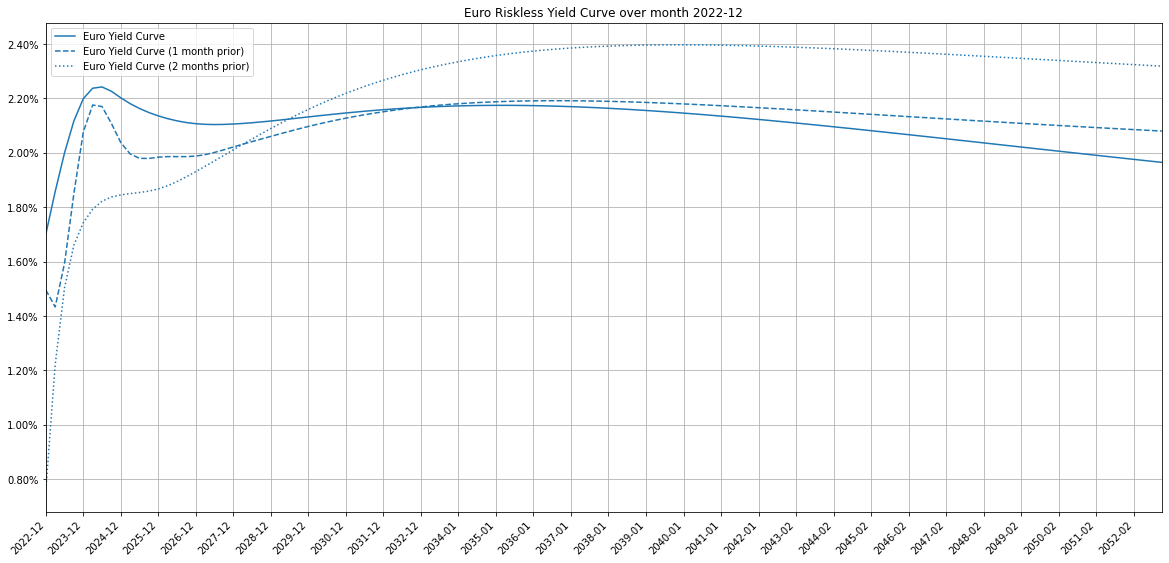

In [23]:
ax = df.iloc[:,0:1].plot(figsize=(20,10), grid=True,
             title='Euro Riskless Yield Curve over month ' + date_now.strftime('%Y-%m'),
             xlim=(df.index[0], df.index[-1]), xticks=df.index[::4], xlabel='', rot=45)
df.iloc[:,1:2].plot(ax=ax, grid=True, xticks=df.index[::4], rot=45, linestyle='--', color=['#1f77b4'])
df.iloc[:,2:3].plot(ax=ax, grid=True, xticks=df.index[::4], rot=45, linestyle=':', color=['#1f77b4'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, df.index[::4])))

In [24]:
print('An average shift of {:.2f}bp between {:%Y-%m} and {:%Y-%m}'.format(
    (df.iloc[:,0]-df.iloc[:,1]).mean() * 10000,
    euro_par_yields.index[-1].date(), euro_par_yields.index[-2].date()))

An average shift of -0.15bp between 2022-12 and 2022-11


In [25]:
print('An average shift of {:.2f}bp between {:%Y-%m} and {:%Y-%m}'.format(
    (df.loc[:'2032',df.columns[0]]-df.loc[:'2032',df.columns[1]]).mean() * 10000,
    euro_par_yields.index[-1].date(), euro_par_yields.index[-2].date()))

An average shift of 9.81bp between 2022-12 and 2022-11


In [26]:
print('An average shift of {:.2f}bp between {:%Y-%m} and {:%Y-%m}'.format(
    (df.loc['2032':,df.columns[0]]-df.loc['2032':,df.columns[1]]).mean() * 10000,
    euro_par_yields.index[-1].date(), euro_par_yields.index[-2].date()))

An average shift of -5.05bp between 2022-12 and 2022-11
